In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_csv('Churn_Modelling.csv')

In [3]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# It's obvious that RowNumebr, CustomerId, Surname are irrelevant information. So we remove them.

In [17]:
X = dataset.iloc[:, 3:13]
y = dataset.iloc[:, 13]

In [15]:
import seaborn as sns

In [26]:
dataset.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

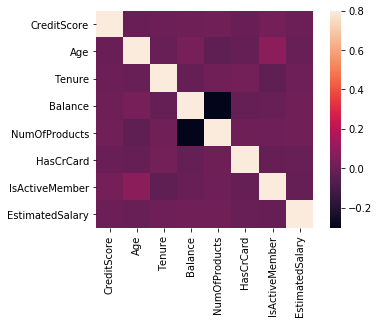

In [20]:
corrmat = X.corr()
sns.heatmap(corrmat, vmax=.8, square=True)

In [21]:
# Barely any correlation in predictors

In [22]:
##### Data Preprocessing #####
# Encoding catedorical data

In [23]:
# convert dataframe to numpy array
X = X.values
y = y.values

In [27]:
# Label encoding Country and Gender
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

In [30]:
# One hot encoding on Country. No need for Gender as there are only 2 categories
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
#  Remove 1 dummy variable
X = X[:, 1:]

In [31]:
# Splitting the dataset into Training set and Test set

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [33]:
# Feature Scaling

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [35]:
##### Logistic Regression #####

In [40]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier_logi = LogisticRegression(random_state = 0)
classifier_logi.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_logi.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_logi = confusion_matrix(y_test, y_pred)
acc_logi = (cm_logi[0,0] + cm_logi[1,1]) / len(y_test)

In [41]:
acc_logi

0.811

In [42]:
# Cross Validation

In [43]:
from sklearn.model_selection import cross_val_score

In [68]:
accuracies_logi = cross_val_score(estimator = classifier_logi, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')

In [69]:
acc_mean_logi = accuracies_logi.mean()
acc_var_logi = accuracies_logi.std()

In [70]:
acc_mean_logi

0.8083747220698783

In [71]:
acc_var_logi

0.008393320955182004

In [49]:
# We have reched the accuracy of 80.8% with 0.8% variance. Pretty valid model!
# Accuracy of test set is 81.1%, which is very close to the training set. No overfitting.

In [52]:
##### KNN #####

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [88]:
numNeighbors = [x for x in range(3, 50) if x % 2 != 0]

In [102]:
cv_scores_knn = []

In [103]:
for k in numNeighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores_knn.append(scores)

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1ba14860>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1b9b0160>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1ba14438>,
 'medians': [<matplotlib.lines.Line2D at 0x1a1b9b09b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1b9b0dd8>,
 'means': []}

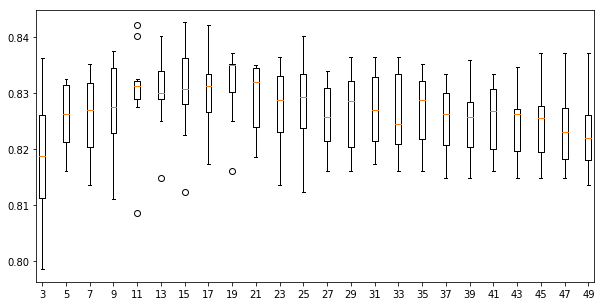

In [135]:
plt.figure(figsize=(10,5))
plt.boxplot(cv_scores_knn, positions = numNeighbors)

In [117]:
# We get the optimal k value: 19
acc_mean_knn = cv_scores_knn[8].mean()

In [118]:
acc_std_knn = cv_scores_knn[8].std()

In [119]:
acc_mean_knn

0.8316228630825986

In [120]:
acc_std_knn

0.006262373711625498

In [122]:
# We have reched the accuracy of 83.2% with 0.62% variance. Valid Model!

In [128]:
# Predicting the Test set results
classifier_knn = KNeighborsClassifier(n_neighbors=19)
classifier_knn.fit(X_train, y_train)
y_pred = classifier_knn.predict(X_test)


In [138]:
# Making the Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred)
acc_knn = (cm_knn[0,0] + cm_knn[1,1]) / len(y_test)

In [139]:
acc_knn

0.846

In [132]:
# Looks like it's better than Logistic!

In [136]:
##### Random Forest #####

In [137]:
# Fitting Random Forest Classification to the Training set
# We chose 128 trees as typically more tree means more accuracy.
# However, there's an research showing that no significant improvement after 128 trees
from sklearn.ensemble import RandomForestClassifier
classifier_randomforest = RandomForestClassifier(n_estimators = 128, criterion = 'entropy', random_state = 0)
classifier_randomforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [140]:
# Predicting the Test set results
y_pred = classifier_randomforest.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_randomforest = confusion_matrix(y_test, y_pred)
acc_randomforest = (cm_randomforest[0,0] + cm_randomforest[1,1]) / len(y_test)

In [141]:
acc_randomforest

0.871

In [142]:
# Cross Validation

In [143]:
accuracies_randomforest = cross_val_score(estimator = classifier_randomforest, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')

In [221]:
acc_mean_randomforest = accuracies_randomforest.mean()
acc_var_randomforest = accuracies_randomforest.std()

In [145]:
acc_mean_randomforest

0.8083747220698783

In [146]:
acc_var_randomforest

0.008393320955182004

In [147]:
# We are expecting 80.8% accuracy with 0.8% varaince for test data.
# We are really lucky to reach 87.1% accuracy of test set. It's probably because we don;t have enough test set.

In [148]:
##### XGBOOSTING #####

In [150]:
from xgboost import XGBClassifier
classifier_xgboost = XGBClassifier()
classifier_xgboost.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_xgboost.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_xgboost = confusion_matrix(y_test, y_pred)
acc_xgboost = (cm_xgboost[0,0] + cm_xgboost[1,1]) / len(y_test)

/Users/Joy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [151]:
acc_xgboost

0.8645

In [155]:
accuracies_xgboost = cross_val_score(estimator = classifier_xgboost, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
acc_mean_xgboost = accuracies_xgboost.mean()
acc_var_xgboost = accuracies_xgboost.std()

/Users/Joy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Joy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Joy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Joy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

In [156]:
acc_mean_xgboost

0.8629994451163204

In [157]:
acc_var_xgboost

0.010677872171663988

In [158]:
# We are expecting 86.3% accuracy with 1.1% varaince for test data.
# XGBOOSTING rocks!

In [159]:
##### ANN #####
##### ANN is performed on keras in tensorflow backend #####

In [164]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [170]:
def build_classifier(optimizer):
    # Initialising the ANN
    classifier = Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dropout(p = 0.1))
    
    # Adding the second hidden layer
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dropout(p = 0.5))
    
    # Adding the output layer
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    # Compiling the ANN
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [171]:
classifier_ann = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [32, 64, 128, 256],
              'epochs': [100, 500, 1000],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier_ann,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

In [ ]:
##### Warning! Time Consuming step #####
grid_search = grid_search.fit(X_train, y_train);

/Users/Joy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  import sys
/Users/Joy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100


In [278]:
best_parameters = grid_search.best_params_ 
best_accuracy = grid_search.best_score_ 
best_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
accuracies_ann = grid_search.grid_scores_[grid_search.best_index_].cv_validation_scores

/Users/Joy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [184]:
best_parameters

{'batch_size': 128, 'epochs': 100, 'optimizer': 'rmsprop'}

In [185]:
best_accuracy

0.8075

In [186]:
best_std

0.025968731197345784

In [275]:
##### Conclusion #####
df =np.asarray([accuracies_logi, cv_scores_knn[8], accuracies_randomforest, accuracies_xgboost, accuracies_ann]).T

In [276]:
df = pd.DataFrame(df)

[Text(0,0,'logi'),
 Text(0,0,'knn'),
 Text(0,0,'randomforest'),
 Text(0,0,'xgboost'),
 Text(0,0,'ann')]

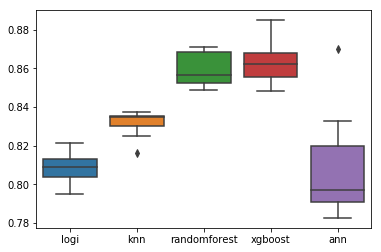

In [277]:
g = sns.boxplot(data=df)
g.set_xticklabels(["logi", "knn", "randomforest", "xgboost", "ann"])

In [ ]:
##### Conclusion #####

In [ ]:
##### Not recommending ANN, it's extremely time consuming and not that good for this problem
##### It's performance is even worse than the simple logistic regression, which suggested that the data probably has high linearity.
##### XGBoost (Boosting method) rocks for structured data, fast and accurate
##### Randomforest (Bagging method) is not bad either